In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow --upgrade

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 79.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstall

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
vocab_size = 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

maxlen = 200
#Pad sequences:
print('Pad sequences (samples x time)')
input_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
input_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Pad sequences (samples x time)
input_train shape: (25000, 200)
input_test shape: (25000, 200)


In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [6]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed-forward network inside the transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=False)
x = layers.GlobalAveragePooling1D()(x) #add global average pooling
x = layers.Dropout(0.5)(x) #add dropout
x = layers.Dense(20)(x) #add dense layer with about 20 neurons
x = layers.Dropout(0.5)(x) #add dropout
outputs = layers.Dense(2, activation='softmax')(x) #add the final dense layer for classification

model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    input_train, y_train, batch_size=32, epochs=15, validation_data=(input_test, y_test)
)

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.6517 - loss: 0.6380 - val_accuracy: 0.8709 - val_loss: 0.3067
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9105 - loss: 0.2385 - val_accuracy: 0.8746 - val_loss: 0.3057
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9494 - loss: 0.1499 - val_accuracy: 0.8636 - val_loss: 0.3732
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9725 - loss: 0.0917 - val_accuracy: 0.8548 - val_loss: 0.4721
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9831 - loss: 0.0578 - val_accuracy: 0.8496 - val_loss: 0.6135
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9864 - loss: 0.0422 - val_accuracy: 0.8354 - val_loss: 0.7541
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9912 - loss: 0.0308 - val_accuracy: 0.8399 - val_loss: 0.7762
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9935 - loss: 0.0231 - val_accurac

In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

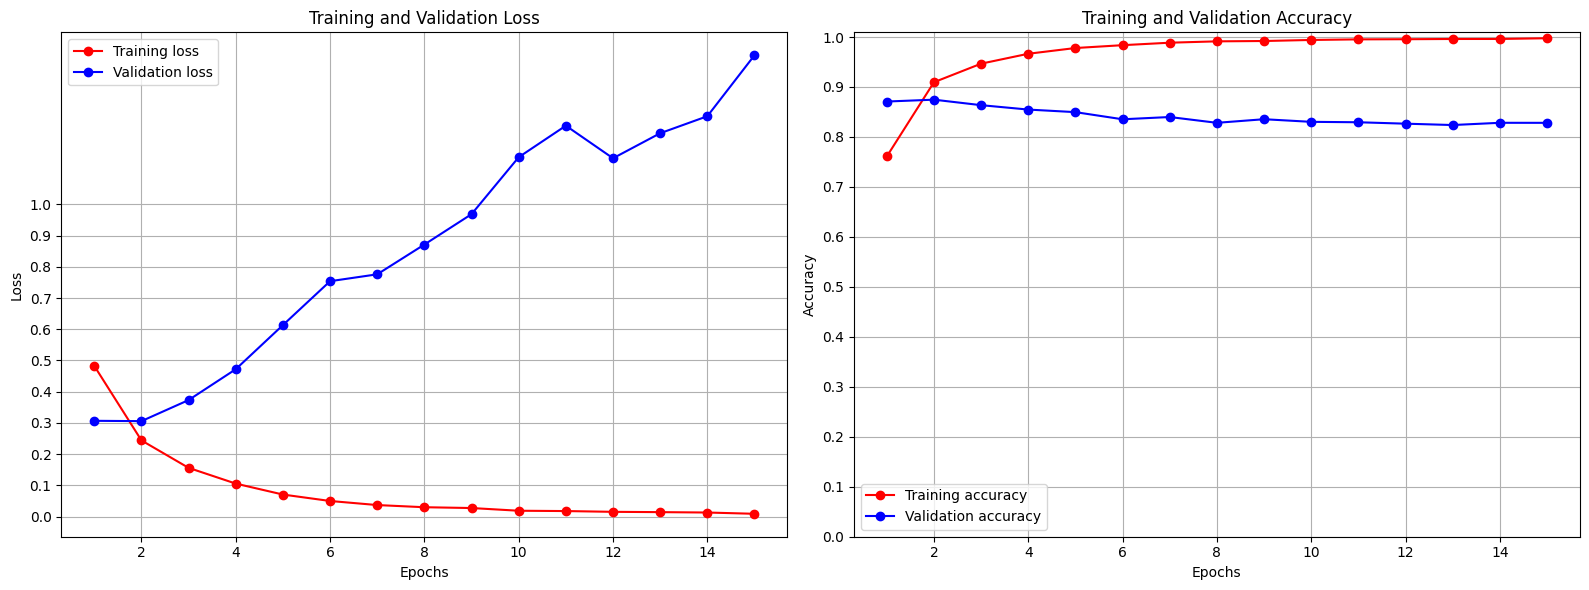

In [10]:
epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.show()

In [1]:
!pip install --upgrade tensorflow==2.15.0

In [2]:
!pip install --quiet vit-keras
!pip install --quiet tensorflow-addons

from vit_keras import vit
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
#TO DO Import dataset or ganaerate it using tf.data or ImageDataGenerator. Preprocess and augment the images.

vit_model = vit.vit_b32(
        image_size = #todo,
        activation = #todo, softmax, sigmoid, etc. does not matter if you are not including top
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes =) #todo)

#TO DO Add Dense layers on top of ViT feature extractor.

#Compile and fit the model.

#plot training and validation loss and accuracy

In [ ]:
from vit_keras import visualize

image = #todo load a single image

attention_map = visualize.attention_map(model = vit_model, image = image)

#Attention map will be an oryginal image with some areas darker and some lighter. if you want to create a proper heatmap, you will need to manually apply a colormap.

1/1 [==============================] - 2s 2s/step
Prediction: Eskimo dog, husky


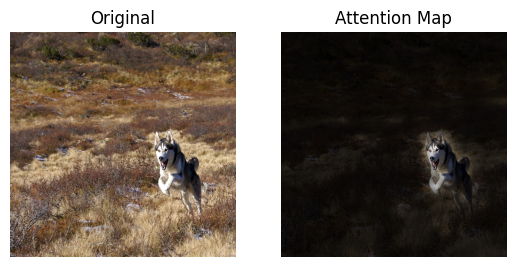

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from vit_keras import vit, utils, visualize

# Load a model
image_size = 384
classes = utils.get_imagenet_classes()
model = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=True
)
classes = utils.get_imagenet_classes()

# Get an image and compute the attention map
url = 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Free%21_%283987584939%29.jpg'
image = utils.read(url, image_size)
attention_map = visualize.attention_map(model=model, image=image)
print('Prediction:', classes[
    model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]
)  # Prediction: Eskimo dog, husky

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)